In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import linregress
from Higgs.tools.ImplementationUtils import readHEPDataCsv, implementChannelWidthLimit
import Higgs.bounds as HB
from Higgs.tools.LimitValidation import validateChannelWidthLimit
import Higgs.predictions as HP


def toFittedFun(coeffs):
    return lambda m: coeffs[0] + coeffs[1] * (m - 225.0) + coeffs[2] * np.log(m)


## ATLAS `H+gam>jj` 80fb-1 [1901.10917](https://arxiv.org/abs/1901.10917)

The implementation is from [2103.07484](https://arxiv.org/abs/2103.07484)

### Step 1: Mass shifts

In the original implementation these were taken as final state dependent, but they really vary by less than 3% over all final states, so we just average them all through a linear fit (see plot) and use that one instead. Since it is now the same shift for all channels, we can simply convert the limit from the gaussian mass to the particle mass once and then we don't need to do any mass shifts in the implementation.

channels for which the mass shift differs by more than 3% []


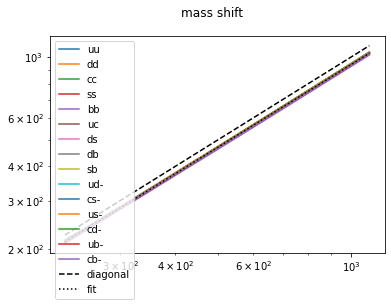

In [2]:
singlePhotonShiftedMass = {
    "uu": [281.4319562313968e0, 0.9673914266961734e0, -12.235462255102286e0],
    "dd": [258.81946927233946e0, 0.9633838763717543e0, -8.394837719212434e0],
    "cc": [224.11771622447955e0, 0.9529383908273734e0, -2.1334395373697994e0],
    "ss": [284.55872258550187e0, 0.9525467718329332e0, -12.822919404917098e0],
    "bb": [220.9499460459883e0, 0.9266918231874117e0, -2.069497910863455e0],
    "uc": [289.3880456860291e0, 0.9629350202691872e0, -13.78476867531609e0],
    "ds": [193.21640722258093e0, 0.9349332966650078e0, 3.7982633636725636e0],
    "db": [216.08451117396797e0, 0.9327140780790565e0, -0.8275101427359572e0],
    "sb": [238.35298494195436e0, 0.9419221069111677e0, -4.847633989956753e0],
    "ud-": [272.117378980746e0, 0.9685260914441841e0, -10.599655101495404e0],
    "cs-": [258.9945452730261e0, 0.9564116331738203e0, -8.177737850503428e0],
    "us-": [154.2868145807532e0, 0.923627818671771e0, 10.522652458614687e0],
    "cd-": [243.18626334632324e0, 0.9531014690805794e0, -5.539394174464264e0],
    "ub-": [273.31450166305825e0, 0.954571643579162e0, -11.148508503812018e0],
    "cb-": [209.0255570171927e0, 0.9211762223473134e0, 0.6774235947175775e0],
}

combinedTriggerShiftedMass = {
    "uu": [268.6419095201171e0, 0.9600671239644399e0, -9.859514713821117e0],
    "dd": [272.21432619456056e0, 0.9643979603066067e0, -10.626478039631243e0],
    "cc": [254.35644581068794e0, 0.9611958334854936e0, -7.505911098316428e0],
    "ss": [254.71289010244473e0, 0.9425188137399285e0, -7.543214214890992e0],
    "bb": [267.9237702016445e0, 0.9388069130521747e0, -10.263128783184035e0],
    "uc": [280.28817594827103e0, 0.9587600118446112e0, -12.115839738882553e0],
    "ds": [223.71851983237093e0, 0.9454616308413796e0, -1.7582329141468864e0],
    "db": [233.5373585585733e0, 0.9367802595332158e0, -3.953300640830744e0],
    "sb": [229.9860946965195e0, 0.9387178657637238e0, -3.373496593320827e0],
    "ud-": [276.0391663421334e0, 0.9661644772641924e0, -11.14797232157632e0],
    "cs-": [242.3824874015853e0, 0.9481249846138476e0, -5.194289746546004e0],
    "us-": [221.30860410941688e0, 0.9471664169027666e0, -1.4268813388883332e0],
    "cd-": [225.17451363750908e0, 0.9431376149033346e0, -2.241990843366313e0],
    "ub-": [264.80736830157275e0, 0.9503271038762466e0, -9.478877550413694e0],
    "cb-": [253.24791198178133e0, 0.9382083805622718e0, -7.390505995052736e0],
}

singlePhotonRange = np.linspace(225, 450)
combinedTriggerRange = np.linspace(450, 1100)
totalRange = np.concatenate([singlePhotonRange, combinedTriggerRange])

shiftedMassDisc = {
    k: np.concatenate(
        [
            toFittedFun(singlePhotonShiftedMass[k])(singlePhotonRange),
            toFittedFun(combinedTriggerShiftedMass[k])(combinedTriggerRange),
        ]
    )
    for k in combinedTriggerShiftedMass.keys()
}


print(
    "channels for which the mass shift differs by more than 3%",
    [
        (k1, k2)
        for (k1, v1), (k2, v2) in itertools.product(
            shiftedMassDisc.items(), shiftedMassDisc.items()
        )
        if not np.allclose(v1, v2, rtol=0.03)
    ],
)

fit = linregress(
    np.tile(totalRange, len(shiftedMassDisc)),
    np.concatenate(list(shiftedMassDisc.values())),
)


fig, ax = plt.subplots()
for k, v in shiftedMassDisc.items():
    ax.plot(totalRange, v, label=k)
ax.plot(totalRange, totalRange, c="k", ls="--", label="diagonal")
ax.plot(totalRange, fit.slope * totalRange + fit.intercept, c="k", label="fit", ls=":")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
fig.suptitle("mass shift")
plt.show()


def toGaussianMass(particleMass):
    return fit.slope * particleMass + fit.intercept


def toParticleMass(gaussianMass):
    return (gaussianMass - fit.intercept) / fit.slope


singlePhotonRange = np.linspace(toParticleMass(225), toParticleMass(449.9))
combinedTriggerRange = np.linspace(toParticleMass(450), toParticleMass(1050))
totalRange = np.concatenate([singlePhotonRange, combinedTriggerRange])


### Preselection and final state acceptances

Now we load all of the acceptances. These do indeed depend relevantly on the final/initial states.

Text(0.5, 0.98, 'final selection')

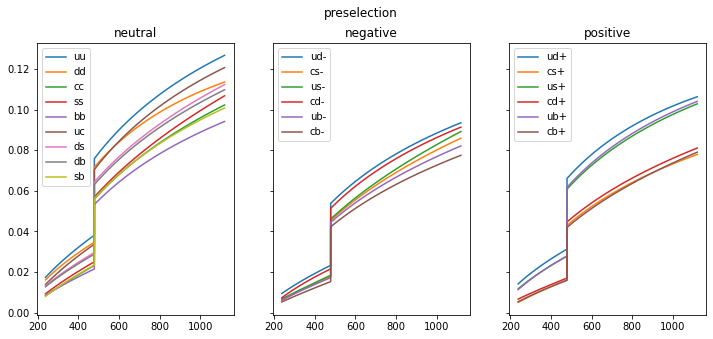

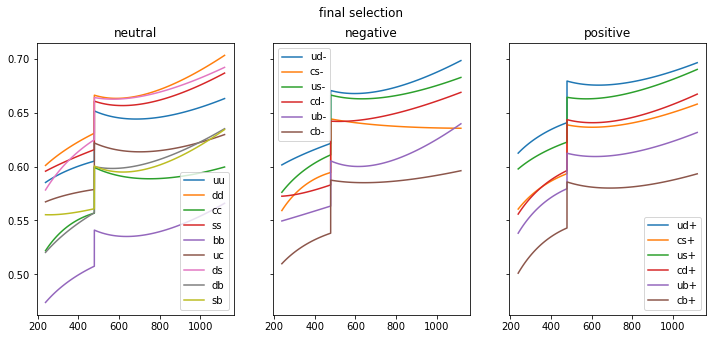

In [3]:
singlePhotonPreselection = {
    "uu": [-0.07453818172065914e0, 3.824816674227349e-05, 0.016692363267610276e0],
    "dd": [-0.08365502599272057e0, 2.472432083149923e-05, 0.018160770096650507e0],
    "cc": [-0.03036038738244472e0, 4.221832611704063e-05, 0.006949082950767061e0],
    "ss": [-0.04243315863987981e0, 3.866314211122518e-05, 0.009348295231225559e0],
    "bb": [-0.02914949139483562e0, 3.419393921510185e-05, 0.006807103486670389e0],
    "uc": [-0.0689894294152424e0, 3.8902627867545764e-05, 0.015043024297551865e0],
    "ds": [-0.0453815009102044e0, 3.744108513321609e-05, 0.010614770882040572e0],
    "db": [-0.048765522647684335e0, 3.456462028873385e-05, 0.01114951745281092e0],
    "sb": [-0.04967090498121169e0, 3.350800124436956e-05, 0.010467748237181393e0],
    "ud-": [-0.04484663445244751e0, 2.917809069238506e-05, 0.009845381304258653e0],
    "cs-": [-0.02438929995556706e0, 3.289201683319401e-05, 0.005487672382653153e0],
    "us-": [-0.008308403859409175e0, 4.0866452739329755e-05, 0.0026511859056011886e0],
    "cd-": [-0.0620312387951807e0, 2.267517735452839e-05, 0.012612883806140607e0],
    "ub-": [-0.023580025808217338e0, 3.0657222293821745e-05, 0.005352044311661076e0],
    "cb-": [-0.012801225226009098e0, 3.236168398393879e-05, 0.0032221044092733972e0],
    "ud+": [-0.07335163824881155e0, 2.520750232361978e-05, 0.01592191407492654e0],
    "cs+": [-0.029160671828213205e0, 2.8358926187903368e-05, 0.006174353616870782e0],
    "us+": [-0.06261671128216949e0, 2.7693711065568606e-05, 0.01351445163517528e0],
    "cd+": [-0.014512733956164226e0, 3.2090057309420846e-05, 0.0037939580782129917e0],
    "ub+": [-0.07217431189967927e0, 2.5143326400233142e-05, 0.015194175446230258e0],
    "cb+": [-0.032923747335909186e0, 2.375420069088394e-05, 0.006937870226189841e0],
}

singlePhotonFinalSelection = {
    "uu": [0.38525532656239947e0, -2.3628125387441066e-05, 0.036583038825438785e0],
    "dd": [0.39943561504923303e0, 1.784454676602849e-05, 0.03677608469507186e0],
    "cc": [-0.08698019570012273e0, -0.00017882404715921708e0, 0.11167279264415338e0],
    "ss": [0.5248353167619432e0, 4.6061903293067066e-05, 0.01282638879632233e0],
    "bb": [0.14312123365961413e0, -3.5483692688954893e-05, 0.060523486229233724e0],
    "uc": [0.4373782503387766e0, -2.1099726560508866e-05, 0.023776375433901743e0],
    "ds": [0.09950722594177391e0, -5.9714373125369575e-05, 0.08759342621226496e0],
    "db": [0.2548839475478191e0, 1.2711069457280673e-05, 0.04845909024311625e0],
    "sb": [0.6817853117541732e0, 9.064290919677945e-05, -0.023320207176590838e0],
    "ud-": [0.5044416517236326e0, 3.185865787709505e-05, 0.017651476316145345e0],
    "cs-": [-0.058784400414788184e0, -0.00018154856031669657e0, 0.11332390252462604e0],
    "us-": [0.16119824265350222e0, -7.56869322478831e-05, 0.07597218513158863e0],
    "cd-": [0.710682341234595e0, 0.00011764645546976406e0, -0.025532282301762386e0],
    "ub-": [0.5598552848055856e0, 6.35468637968493e-05, -0.002042606314717672e0],
    "cb-": [0.1535119999958045e0, -7.130706112897657e-05, 0.06527192110263923e0],
    "ud+": [0.28920582367011693e0, -5.392197698683376e-05, 0.059170447528441354e0],
    "cs+": [0.1360543536099816e0, -8.8595728151652e-05, 0.07775522896899756e0],
    "us+": [0.36403229644970786e0, -2.0313192545953587e-05, 0.04273987985113689e0],
    "cd+": [0.03753114628032014e0, -0.00010725799982331615e0, 0.09494959625977027e0],
    "ub+": [-0.058835087810597805e0, -0.00014543013924738662e0, 0.10940912532011073e0],
    "cb+": [-0.12533421966904126e0, -0.00015829179090177497e0, 0.11481519723740238e0],
}

combinedTriggerPreselection = {
    "uu": [-0.3495397605469713e0, -1.2642459929452903e-05, 0.06945421537488733e0],
    "dd": [-0.3471775210703532e0, -2.5919492355969983e-05, 0.06893383402208757e0],
    "cc": [-0.25771965185274837e0, 5.2868594897241616e-06, 0.05060836725764018e0],
    "ss": [-0.2161349881915616e0, 2.0265589959806386e-05, 0.04342174072764107e0],
    "bb": [-0.2613043396316116e0, -3.894324500526707e-06, 0.051132326713863516e0],
    "uc": [-0.3485345843201749e0, -1.223497402338667e-05, 0.06839930939545714e0],
    "ds": [-0.25385483138026416e0, 6.894729090512683e-06, 0.05128069341398131e0],
    "db": [-0.2726412110713955e0, 7.846779718611548e-07, 0.054373087775165e0],
    "sb": [-0.2784463150279004e0, -2.3232981890858514e-06, 0.054315795840985275e0],
    "ud-": [-0.25710823612127615e0, -5.034398780010226e-06, 0.05058736718447029e0],
    "cs-": [-0.18967205251280128e0, 1.3486331956279841e-05, 0.037541628609521455e0],
    "us-": [-0.16896121633864306e0, 2.2335584697813463e-05, 0.033933534398936774e0],
    "cd-": [-0.25812436133618843e0, -4.261253080856257e-06, 0.050327388108494284e0],
    "ub-": [-0.19271439731198028e0, 8.241909640369068e-06, 0.03809804952102698e0],
    "cb-": [-0.1848252094694455e0, 6.595742525862169e-06, 0.036528211472614765e0],
    "ud+": [-0.32901275609576014e0, -2.329295062067327e-05, 0.06498087881664942e0],
    "cs+": [-0.2138055657620705e0, -5.777785130482657e-07, 0.04162969122251766e0],
    "us+": [-0.29351696001599786e0, -1.115565824728008e-05, 0.057883413664741076e0],
    "cd+": [-0.19235684407120268e0, 6.230537342199852e-06, 0.038157270574518884e0],
    "ub+": [-0.3087878807658839e0, -1.4223220997063607e-05, 0.060621421727487405e0],
    "cb+": [-0.17933973462875433e0, 1.0897748362352643e-05, 0.035417916916325634e0],
}

combinedTriggerFinalSelection = {
    "uu": [1.4179009959807805e0, 0.00019318402078541907e0, -0.13213062021217128e0],
    "dd": [1.5431432938623932e0, 0.0002603304761813639e0, -0.15281513143882092e0],
    "cc": [1.2978470088122862e0, 0.00015943440694614355e0, -0.11976935313211168e0],
    "ss": [1.4554725336733858e0, 0.00022367903663272575e0, -0.1380001570888785e0],
    "bb": [1.4594279432344206e0, 0.0002497796055038875e0, -0.15908339475374172e0],
    "uc": [1.352570526510758e0, 0.00017897228740841698e0, -0.12577105956572918e0],
    "ds": [1.2528303938956713e0, 0.0001800583268401668e0, -0.10282440526626438e0],
    "db": [1.3204031551147875e0, 0.00022174772906246543e0, -0.12586100686977048e0],
    "sb": [1.6547033810359737e0, 0.00029549146128929273e0, -0.1829824410338565e0],
    "ud-": [1.3818977638832035e0, 0.00020755445448888415e0, -0.12381726801188014e0],
    "cs-": [0.8143455081368138e0, 2.4380225860519337e-05, -0.02858203998980347e0],
    "us-": [1.24000868172595e0, 0.00015736056718772585e0, -0.09943870123404218e0],
    "cd-": [1.039022396261481e0, 0.0001343541213216677e0, -0.06984861338158219e0],
    "ub-": [1.6368519487358948e0, 0.00029132603866931765e0, -0.1791466833427859e0],
    "cb-": [0.9315940135101826e0, 9.266106762835439e-05, -0.059585540188055924e0],
    "ud+": [1.288081714061273e0, 0.00016647838199530424e0, -0.10550214628762097e0],
    "cs+": [1.1585741495362076e0, 0.0001499435859582795e0, -0.09041290604805757e0],
    "us+": [1.2135143760634988e0, 0.00016756223554864104e0, -0.09590287762626909e0],
    "cd+": [1.2909510263482682e0, 0.00018627160475987738e0, -0.11257857644665563e0],
    "ub+": [1.2017501461720643e0, 0.00016579167960714954e0, -0.10232834425581878e0],
    "cb+": [1.140050828111984e0, 0.00013845098165656946e0, -0.09551852523990538e0],
}


preselectionDisc = {
    k: np.concatenate(
        [
            toFittedFun(singlePhotonPreselection[k])(singlePhotonRange),
            toFittedFun(combinedTriggerPreselection[k])(combinedTriggerRange),
        ]
    )
    for k in singlePhotonPreselection.keys()
}

finalSelectionDisc = {
    k: np.concatenate(
        [
            toFittedFun(singlePhotonFinalSelection[k])(singlePhotonRange),
            toFittedFun(combinedTriggerFinalSelection[k])(combinedTriggerRange),
        ]
    )
    for k in singlePhotonFinalSelection.keys()
}


def neutralChans(data):
    return {k: v for k, v in data.items() if len(k) == 2}


def posChans(data):
    return {k: v for k, v in data.items() if k.endswith("+")}


def negChans(data):
    return {k: v for k, v in data.items() if k.endswith("-")}


fig, axs = plt.subplots(figsize=(12, 5), ncols=3, sharex=True, sharey=True)
ax = axs[0]
ax.set_title("neutral")
for k, v in neutralChans(preselectionDisc).items():
    ax.plot(totalRange, v, label=k)
ax = axs[1]
ax.set_title("negative")
for k, v in negChans(preselectionDisc).items():
    ax.plot(totalRange, v, label=k)
ax = axs[2]
ax.set_title("positive")
for k, v in posChans(preselectionDisc).items():
    ax.plot(totalRange, v, label=k)
for ax in axs:
    ax.legend()
fig.suptitle("preselection")

fig, axs = plt.subplots(figsize=(12, 5), ncols=3, sharex=True, sharey=True)
ax = axs[0]
ax.set_title("neutral")
for k, v in neutralChans(finalSelectionDisc).items():
    ax.plot(totalRange, v, label=k)
ax = axs[1]
ax.set_title("negative")
for k, v in negChans(finalSelectionDisc).items():
    ax.plot(totalRange, v, label=k)
ax = axs[2]
ax.set_title("positive")
for k, v in posChans(finalSelectionDisc).items():
    ax.plot(totalRange, v, label=k)
for ax in axs:
    ax.legend()
fig.suptitle("final selection")


### 3. compute the combined acceptances for every IS/FS combination


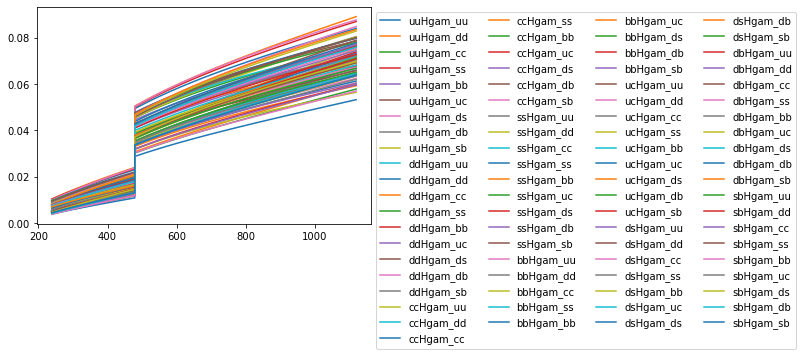

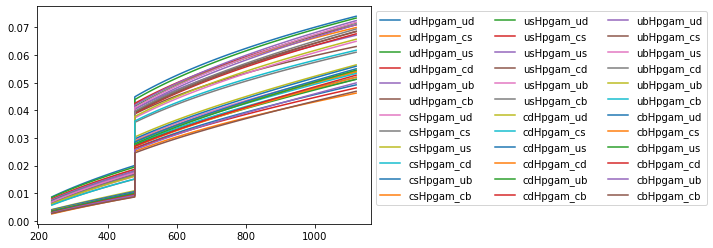

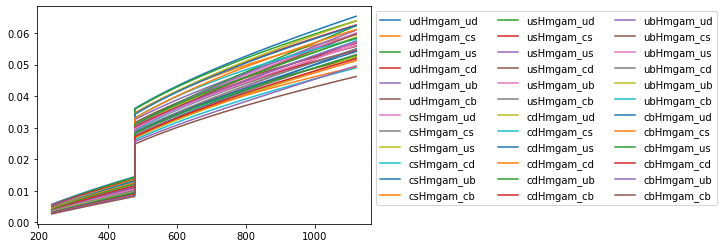

In [4]:
combinedNeutralAcceptances = {
    f"{p}Hgam_{d}": accP * accD
    for (p, accP), (d, accD) in itertools.product(
        neutralChans(preselectionDisc).items(), neutralChans(finalSelectionDisc).items()
    )
}
combinedPosAcceptances = {
    f"{p[:-1]}Hpgam_{d[:-1]}": accP * accD
    for (p, accP), (d, accD) in itertools.product(
        posChans(preselectionDisc).items(), posChans(finalSelectionDisc).items()
    )
}
combinedNegAcceptances = {
    f"{p[:-1]}Hmgam_{d[:-1]}": accP * accD
    for (p, accP), (d, accD) in itertools.product(
        negChans(preselectionDisc).items(), negChans(finalSelectionDisc).items()
    )
}


fig, ax = plt.subplots()
for k, v in combinedNeutralAcceptances.items():
    ax.plot(totalRange, v, label=k)
ax.legend(ncol=4, bbox_to_anchor=(1, 1))

fig, ax = plt.subplots()
for k, v in combinedPosAcceptances.items():
    ax.plot(totalRange, v, label=k)
ax.legend(ncol=3, bbox_to_anchor=(1, 1))

fig, ax = plt.subplots()
for k, v in combinedNegAcceptances.items():
    ax.plot(totalRange, v, label=k)
ax.legend(ncol=3, bbox_to_anchor=(1, 1))


### 4. Actually implementing the limit

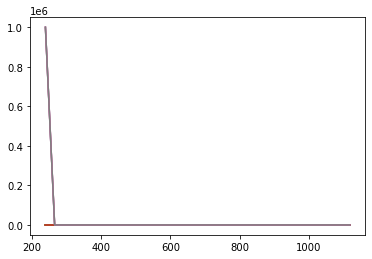

Looks good. Saving this to Hgam_LHC13_ATLAS_80.json


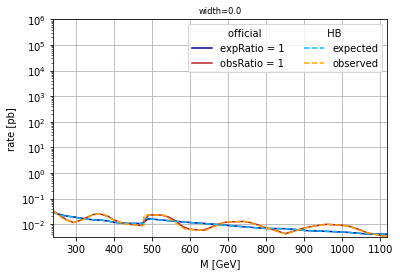

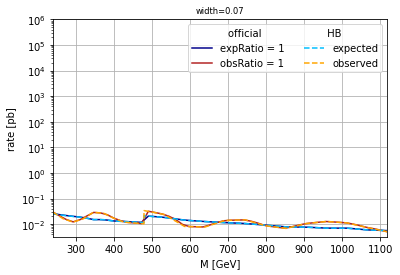

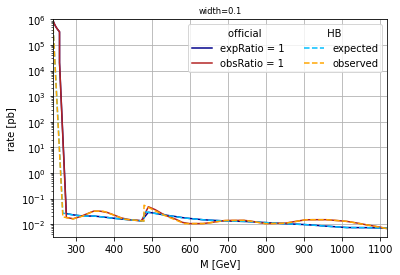

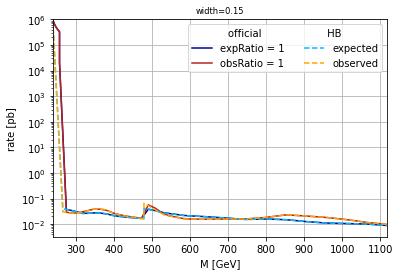

In [8]:
def readTable(i):
    dfs = readHEPDataCsv(
        f"https://www.hepdata.net/download/table/ins1717700/Table%{i}/1/csv",
        na_values="empty",
    )

    for df in dfs:
        if df.columns[1].startswith("Detector resolution"):
            df["normWidth"] = 0
        else:
            df["normWidth"] = float(df.columns[1][-4:])

    def renames(name):
        if name == "$m(G) [GeV]$":
            return "mG"
        elif "obs" in name:
            return "obs"
        elif "exp" in name:
            return "exp"
        return name

    dfs = [df.rename(columns=renames) for df in dfs]
    return pd.merge(
        pd.concat([df for df in dfs if "obs" in df.columns]),
        pd.concat([df for df in dfs if "exp" in df.columns]),
        on=["mG", "normWidth"],
    ).fillna(1e6)


dfSinglePhoton = readTable(205)
dfSinglePhoton.loc[dfSinglePhoton.mG == 450, "mG"] = 449.9
dfCombinedTrigger = readTable(206)
df = pd.concat([dfSinglePhoton, dfCombinedTrigger])
df["m"] = toParticleMass(df.mG)


from scipy.interpolate import interp1d

acceptanceGrid = [
    toParticleMass(225),
    350,
    toParticleMass(449.9),
    toParticleMass(450),
    600,
    800,
    1000,
    toParticleMass(1050),
]

acceptanceFuncs = {
    k: interp1d(totalRange, v)
    for k, v in (
        combinedNeutralAcceptances | combinedPosAcceptances | combinedNegAcceptances
    ).items()
}
acceptanceData = {k: f(acceptanceGrid) for k, f in acceptanceFuncs.items()}


process = {"channels": [x.split("_") for x in acceptanceData.keys()]}
acceptances = [
    {"massDepAcceptance": v, "massGrid": acceptanceGrid}
    for v in acceptanceData.values()
]

limitFile = implementChannelWidthLimit(
    "1901.10917",
    process,
    "https://doi.org/10.17182/hepdata.85763 & 2103.07484",
    df,
    massResolution={"absolute": 0, "relative": 5e-2},  # 3-8% on page 7
    acceptances=acceptances,
    idSuffix=1,
    prefix="Hgam",
)

lim = HB.Limit(limitFile)


def accountForEfficiencies(h, rate):
    for p, d in process["channels"]:
        prevRate = h.channelRate(lim.collider(), p, d)
        if prevRate > 0:
            h.setChannelRate(
                lim.collider(),
                p,
                d,
                h.channelRate(lim.collider(), p, d)
                / acceptanceFuncs["_".join([p, d])](h.mass()),
            )


validateChannelWidthLimit(
    lim, setAdditionalRates=accountForEfficiencies, descInTitle=False
)
